# Estudo de Características

Load

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn import svm, metrics
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

protocol = ['Flexão de punho', 'Extensão de punho', 'Pinça', 'Segurar cartão', 'Segurar caneta', 'Segurar esfera', 'Segurar copo', 'Gancho']
classes = np.repeat(protocol, 99, axis=None)

voluntarios = dict()
for v in range(10):
    voluntarios[v] = np.load(f'./datasets/topicosCC-processed/vol{v}-caracts.npy')


### Visualização

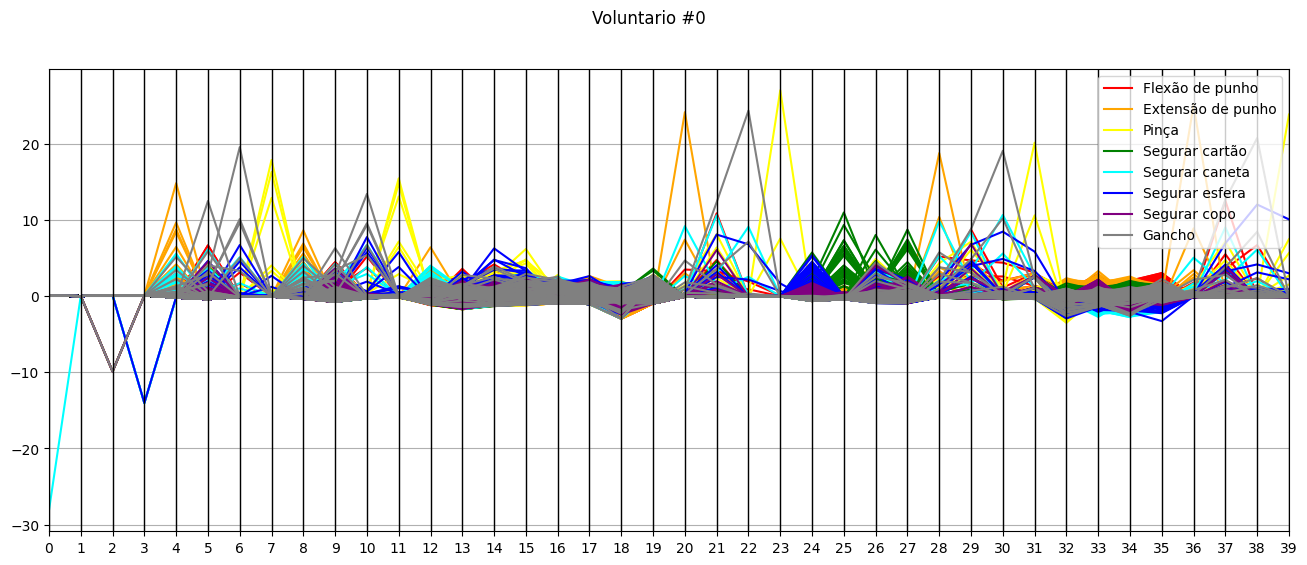

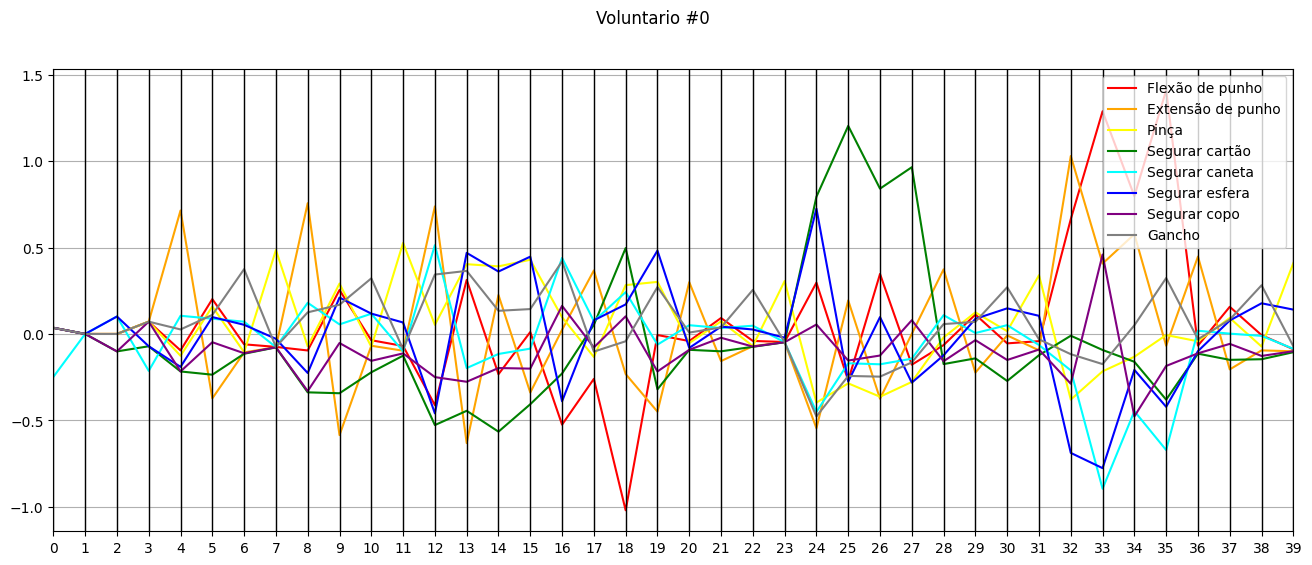

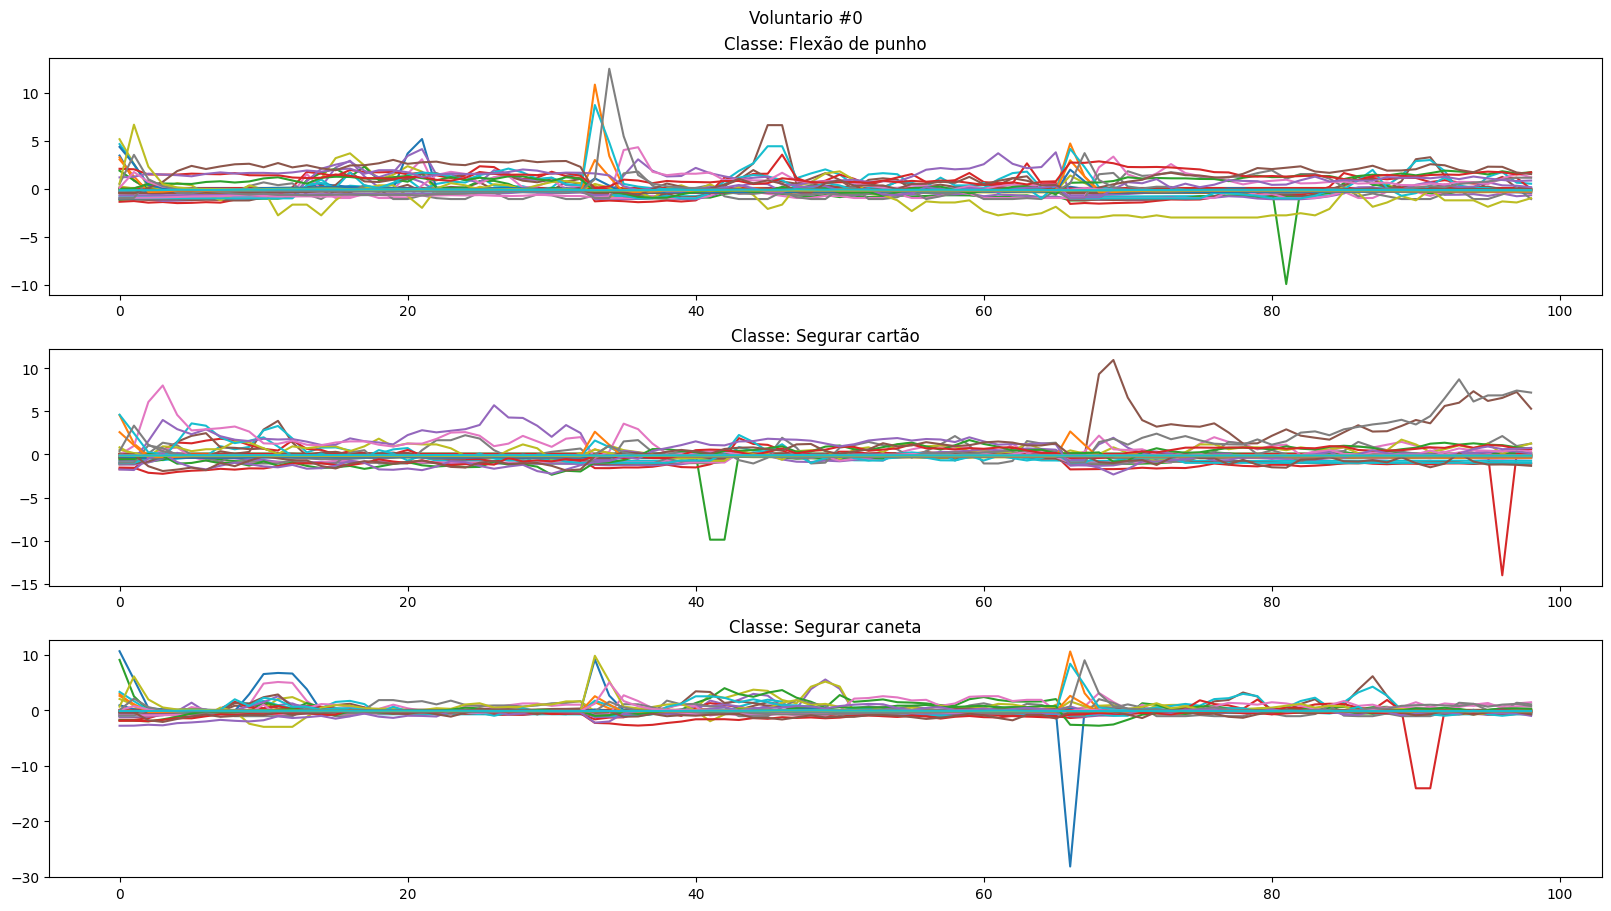

In [21]:
def parallelCoords(voluntario, vol_name='Unnamed', norm=False, avg=False):
    """
    Coord X = Caracteristicas
    Coord Y = Valor das Caracteristicas
    Cor = Protocolo / Tipos de Movimentos
    Linhas = Instancias (linhas da tabela)
    """
    protocol = ['Flexão de punho', 'Extensão de punho', 'Pinça', 'Segurar cartão', 'Segurar caneta', 'Segurar esfera', 'Segurar copo', 'Gancho']

    #preprocessing
    data = np.array(voluntario)
    if norm: data = StandardScaler().fit_transform(data)
    data = pd.DataFrame(data)
    data['classe'] = np.repeat(protocol, 99, axis=None)

    if avg:
        d = [np.array(data.loc[data['classe'] == protocol[i]].mean(numeric_only=True)) for i in range(8)]
        data = pd.DataFrame(d)
        data['classe'] = protocol

    #plot
    rcParams['figure.figsize'] = [16., 6.]
    colormap = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'grey']
    ax = parallel_coordinates(data, 'classe', color=colormap)
    ax.figure.suptitle(f'Voluntario #{vol_name}')
    # ax.figure.figsize = [16., 1.]
    plt.show()
#end pc

def lineGraph(voluntario, vol_name='Unnamed', subplts=None, norm=False):
    """
    Linhas = Caracteristicas
    Coord X = Instancias (linhas da tabela)
    coord Y = Valor da característica para cada instancia (X)
    """
    protocol = ['Flexão de punho', 'Extensão de punho', 'Pinça', 'Segurar cartão', 'Segurar caneta', 'Segurar esfera', 'Segurar copo', 'Gancho']
    
    #preprocessing
    vol = np.array(voluntario)
    if norm: vol = StandardScaler().fit_transform(vol)

    #plot cfg
    if not subplts: subplts = range(len(protocol))
    rcParams['figure.figsize'] = [16., 3. * len(subplts)]
    fig, ax = plt.subplots(len(subplts), 1, constrained_layout=True)
    ax = ax if len(subplts) > 1 else [ax]
    # fig.figsize = [16., 3. * len(subplts)]
    fig.suptitle(f'Voluntario #{vol_name}')

    #plot
    for i, classe in enumerate(subplts):
        # retira dos 792 instancias somente as que a classe for "Classe" (resulta em 99 instancias)
        data = np.array([vol[e,:] for e in range(classe*99, (classe+1)*99)])

        # testamos todas faixas de instâncias para descobrir qual seria a melhor e concluímos que seria 32:36
        # 13:17 também poderia ser uma boa faixa se não fosse pela grande diferença
        ax[i].set_title(f'Classe: {protocol[classe]}')
        ax[i].plot(data)#[:,32:36])
    plt.show()
#end linegraph

parallelCoords(voluntarios[0], vol_name='0', norm=True)
parallelCoords(voluntarios[0], vol_name='0', norm=True, avg=True)
lineGraph(voluntarios[0], vol_name='0', norm=True, subplts=[0, 3, 4])

### Métodos de Extração Automatizada de Características
Pesquisar pelo menos 2 métodos de seleção automatizada de característica. Exceto o método RFE (recursive Feature Elimination): limita o SVM posteriormente a utilizar kernel não linear.


(792, 40)
(792, 39)


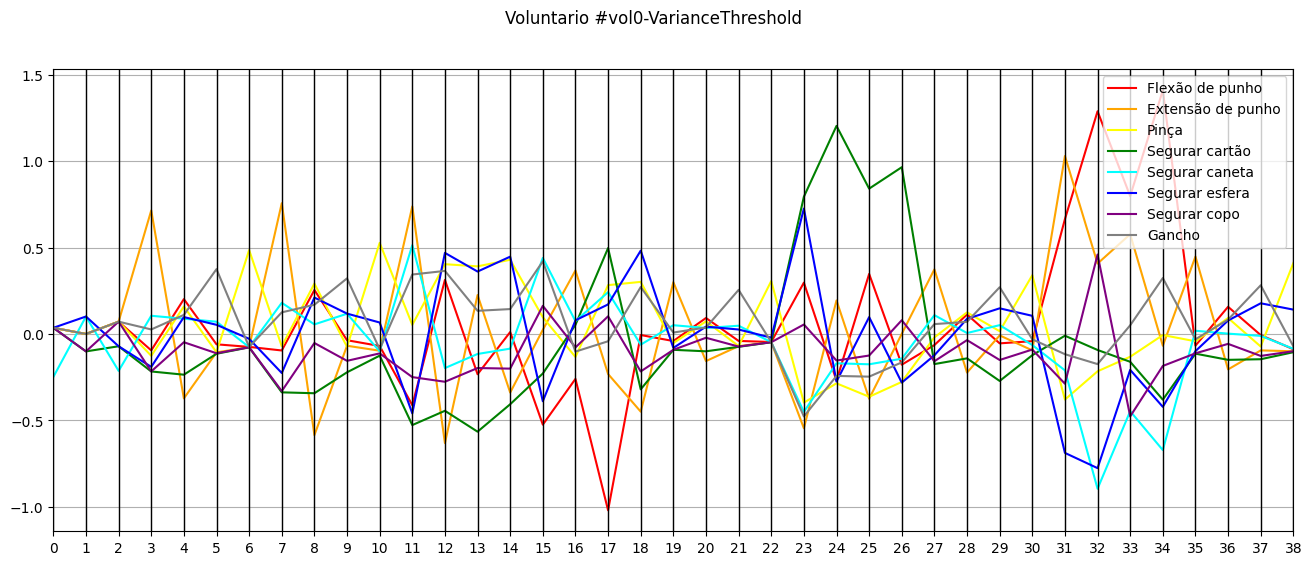

In [22]:
# VARIANCE THRESHOLD
X = voluntarios[0]
X = StandardScaler().fit_transform(X)
print(X.shape)

vt = VarianceThreshold(threshold=0.01)
varX = vt.fit_transform(X)
print(varX.shape)

parallelCoords(varX, vol_name='vol0-VarianceThreshold', avg=True)

(792, 40)
(792, 10)


/home/caio/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/caio/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


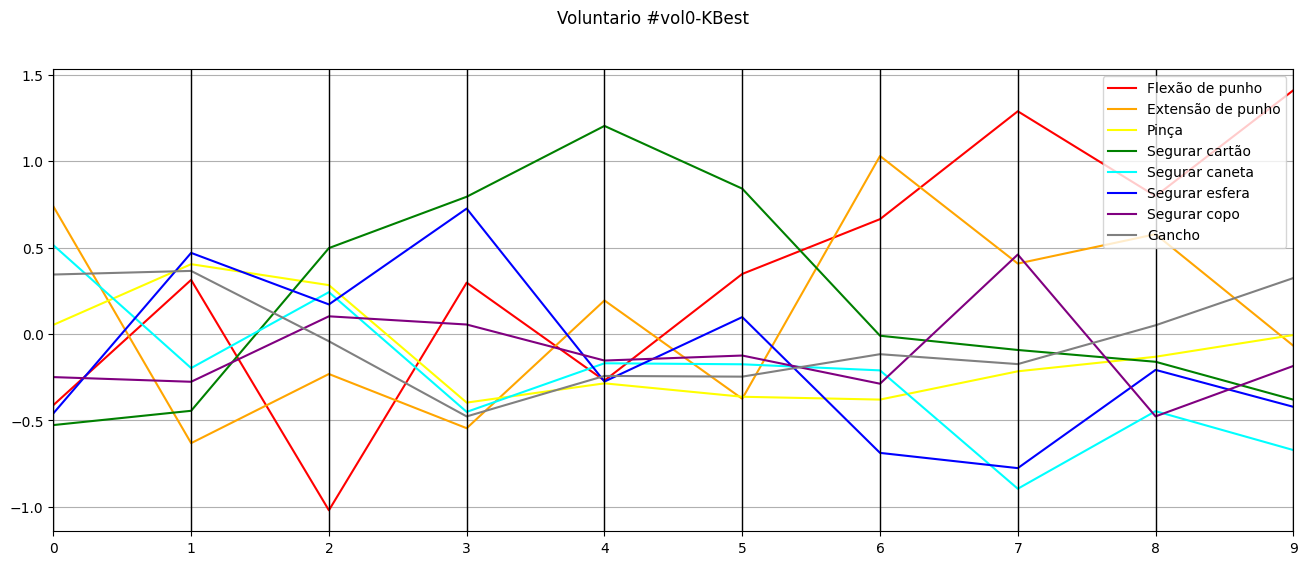

In [23]:
# SELECT K BEST
X = voluntarios[0]
X = StandardScaler().fit_transform(X)
print(X.shape)

kb = SelectKBest(f_classif, k=10)
bestX = kb.fit_transform(X, classes)
print(bestX.shape)

parallelCoords(bestX, vol_name='vol0-KBest', avg=True)

### Teste com SVM simples

In [24]:
### LOAD INSTANCIAS
def testeVoluntario(v, threshold=0.5, kbest=20, save=False):
    X = voluntarios[v]
    Y = np.repeat(protocol, 99, axis=None) # 0,0,0,0,1,1,1,1,2,2,2,2,....7,7,7,7
    print('Origin >', X.shape)
    ### --------------------------------------


    ### SELEÇÃO DE CARACTERISTICAS
    vt = VarianceThreshold(threshold=threshold)
    X = vt.fit_transform(X)
    print('vThresh >', X.shape)

    kb = SelectKBest(f_classif, k=kbest)
    X = kb.fit_transform(X, Y)
    print('kBest >', X.shape)

    if save:
        np.save(f'datasets/topicosCC-processed/vol{v}-selected', X)
    ### --------------------------------------


    ### NORMALIZAÇÃO
    X = StandardScaler().fit_transform(X)
    ### --------------------------------------


    ### DIVISÃO DOS CONJUNTOS TREINO E TESTE
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=2)
    print('Treino >', x_train.shape, len(y_train))
    print('Teste >', x_test.shape, len(y_test))
    ### --------------------------------------


    ### TESTE COM SVM SIMPLES E KNN
    print('*************************** SVM ***************************')
    clf = svm.SVC()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred, digits=5))

    print('*************************** KNN ***************************')
    neigh = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    neigh.fit(x_train, y_train)
    y_pred = neigh.predict(x_test)
    print(metrics.classification_report(y_test, y_pred, digits=5))
    ### --------------------------------------

    ### debug
    # for i in range(len(y_test)):
    #     print(f'{y_test[i]} -> {y_pred[i]}')
#end testvol


for i in range(10):
    testeVoluntario(i, save=True, kbest=30)

# testeVoluntario(5)


Origin > (792, 40)
vThresh > (792, 36)
kBest > (792, 30)
Treino > (633, 30) 633
Teste > (159, 30) 159
*************************** SVM ***************************
                   precision    recall  f1-score   support

Extensão de punho    0.72727   0.72727   0.72727        22
  Flexão de punho    1.00000   0.87500   0.93333        16
           Gancho    0.57692   0.78947   0.66667        19
            Pinça    0.46667   0.43750   0.45161        16
   Segurar caneta    0.73913   0.73913   0.73913        23
   Segurar cartão    1.00000   0.86667   0.92857        15
     Segurar copo    0.79167   0.86364   0.82609        22
   Segurar esfera    0.77273   0.65385   0.70833        26

         accuracy                        0.74214       159
        macro avg    0.75930   0.74407   0.74763       159
     weighted avg    0.75431   0.74214   0.74431       159

*************************** KNN ***************************
                   precision    recall  f1-score   support

Extensã

### Teste com SVM + Grid Search

In [25]:
def gridSearch(v):
    X = voluntarios[v]
    Y = np.repeat(protocol, 99, axis=None) # 0,0,0,0,1,1,1,1,2,2,2,2,....7,7,7,7
    print('Origin >', X.shape)
    ### --------------------------------------


    ### SELEÇÃO DE CARACTERISTICAS
    vt = VarianceThreshold(threshold=0.5)
    X = vt.fit_transform(X)
    print('vThresh >', X.shape)

    kb = SelectKBest(f_classif, k=20)
    X = kb.fit_transform(X, Y)
    print('kBest >', X.shape)

    np.save(f'datasets/topicosCC-processed/vol{v}-selected', X)
    ### --------------------------------------


    ### NORMALIZAÇÃO
    X = StandardScaler().fit_transform(X)
    ### --------------------------------------


    ### DIVISÃO DOS CONJUNTOS TREINO E TESTE
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=2)
    print('Treino >', x_train.shape, len(y_train))
    print('Teste >', x_test.shape, len(y_test))
    ### --------------------------------------

    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': [0.1, 1, 10],
        'degree': [2, 3, 4],
        'coef0': [0, 0.5, 1],
        'tol': [1e-4, 1e-5, 1e-6]
    }

    # Grid search
    grid_search = GridSearchCV(svm.SVC(), param_grid, cv=10)
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predição
    y_pred = best_model.predict(x_test)
    print('Best Params: ', best_params)
    print(metrics.classification_report(y_test, y_pred, digits=5))
#end gridsearch

# for i in range(10):
#     gridSearch(i)

gridSearch(5)

Origin > (792, 40)
vThresh > (792, 34)
kBest > (792, 20)
Treino > (633, 20) 633
Teste > (159, 20) 159
Best Params:  {'C': 10, 'coef0': 0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf', 'tol': 0.0001}
                   precision    recall  f1-score   support

Extensão de punho    0.84000   0.95455   0.89362        22
  Flexão de punho    0.69565   1.00000   0.82051        16
           Gancho    0.94737   0.94737   0.94737        19
            Pinça    0.92857   0.81250   0.86667        16
   Segurar caneta    0.91304   0.91304   0.91304        23
   Segurar cartão    0.86667   0.86667   0.86667        15
     Segurar copo    1.00000   0.90909   0.95238        22
   Segurar esfera    1.00000   0.76923   0.86957        26

         accuracy                        0.89308       159
        macro avg    0.89891   0.89656   0.89123       159
     weighted avg    0.90860   0.89308   0.89444       159

